<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0214%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85)_%EC%8B%9C%EB%AF%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
########################################
# 0. 환경 설정 및 라이브러리 설치 (Colab)
########################################
# Google Drive 연동 (Colab 환경인 경우)
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn xgboost

########################################
# 1. 라이브러리 Import 및 한글 폰트 설정
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Statsmodels & Prophet
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# TensorFlow / Keras & TCN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tcn import TCN

# XGBoost
from xgboost import XGBRegressor

# Optuna
import optuna

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
라이브러리 임포트 및 한글 폰트 설정 완료!


In [ ]:
########################################
# 2. 데이터 로드 및 전처리
########################################
def load_data(data_path):
    """
    여러 인코딩 방식으로 CSV 파일을 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Civil_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [ ]:
df['Cases'] = pd.to_numeric(df['Cases'].str.replace(',', ''), errors='coerce')
# 원본 변수 목록
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)',' 평균최고기온(℃)','평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)','최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

# Cases 차분 변수 추가
df['Cases_Diff'] = df['Cases'].diff(1)

# Date 컬럼 처리 및 정렬
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

In [ ]:

# 간단 EDA 출력
print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      1  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      3  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      1  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      5  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최다일강수량(mm)  평균풍속(m/s)  최대풍속(m/s)  \
0  47.416719      2.2        7.8  ...         0.2        1.5       12.5   
1  52.897434      2.1        7.8  ...         0.7        1.3        9.5   
2  21.600817      1.3        5.7  ...         0.7        2.3       13.1   
3  18.842018      0.1        6.3  ...         2.0        1.8       13.4   
4  11.594881     -3.6        1.0  ...        26.0        3.0       14.7   

   최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  일사합(MJ/m2)  Traffic  Cases_Diff  
0      

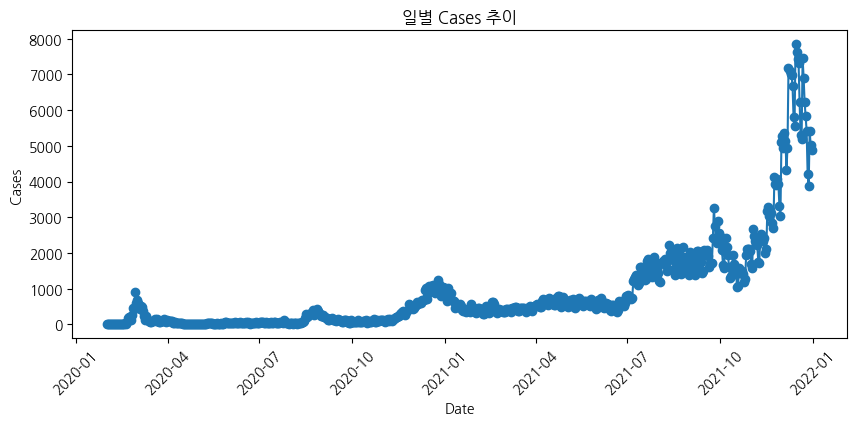

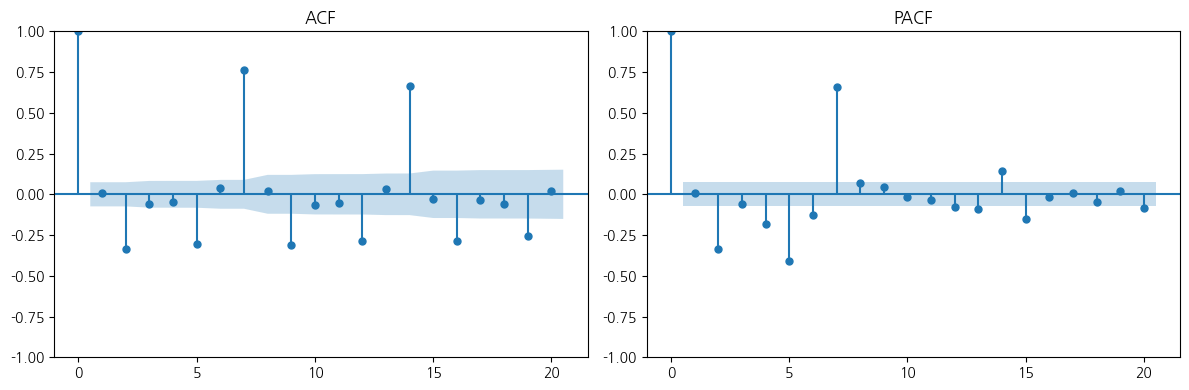

In [ ]:
########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF 및 PACF 플롯
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [ ]:

########################################
# 4. Lag Feature 생성
########################################
def create_lag_features(dataframe, col_targets, lags):
    """
    col_targets에 대해 지정된 lags 만큼의 새로운 컬럼 생성.
    예: lags=(1,7,14) → 'col_target_lag1', 'col_target_lag7', 'col_target_lag14'
    """
    df_ = dataframe.copy()
    for col_target in col_targets:
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [ ]:

import statsmodels.api as sm

# 종속변수: 'Cases'
y = df['Cases']

# 독립변수: 'Cases'와 'Date' 컬럼을 제외한 나머지 모든 컬럼
X = df.drop(['Cases', 'Date'], axis=1)

# 상수항 추가
X = sm.add_constant(X)

# OLS 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 요약 출력 (계수, p-value, R-squared 등 확인 가능)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.509e+24
Date:                Fri, 14 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:37:06   Log-Likelihood:                 12596.
No. Observations:                 686   AIC:                        -2.498e+04
Df Residuals:                     579   BIC:                        -2.449e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.281e-08   4.66e-09     

In [ ]:

# SARIMAX 튜닝 시 사용한 best feature (예시)
# feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10', 'PM25_lag13','평균풍속(m/s)_lag13','Traffic', 'Cases_lag1']
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)',' 평균최고기온(℃)',
            '평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)',
            '최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)',
            '일사합(MJ/m2)','Traffic']
feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10','최고기온(℃)', '일조합(hr)','평균풍속(m/s)','Traffic','Cases_lag1']

In [ ]:

########################################
# 6. 시퀀스 데이터 생성 함수
########################################
def make_sequence_data(X_scaled, y_values, window):
    """
    window 길이만큼 슬라이딩 윈도우로 시퀀스 데이터를 생성합니다.
    X_seq: [샘플 수, window, feature 수]
    y_seq: window 이후의 target 값
    """
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window):
        X_seq.append(X_scaled[i:i+window])
        y_seq.append(y_values[i+window])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
########################################
# 7. 모델 성능 평가 함수
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.3f}")
    return {'model': model_name, 'MAE': mae_value, 'RMSE': rmse_value, 'MAPE': mape_value}

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 11) 테스트세트 크기: (153, 11)


In [ ]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
########################################
# 8-1. SARIMAX (ARIMAX) 예시
########################################

feature_cols = ['SO2','CO','O3','NO2','O3_lag8','PM25','Traffic','Cases_lag1']
#feature_cols = ['SO2','CO','O3','NO2','O3_lag8','PM25','Traffic','Cases_lag1']
def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  533
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -3045.974
Date:                           Fri, 14 Feb 2025   AIC                           6115.949
Time:                                   00:37:52   BIC                           6167.087
Sample:                                        0   HQIC                          6135.975
                                           - 533                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2         2.623e+04   1.87e-05    1.4e+09      0.000    2.62e+04    2.62e+04
CO          -154.6

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
########################################
# 5. Train/Validation/Test 분리 및 스케일링
########################################
feature_cols = ['SO2','CO','O3','NO2','O3','PM25','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']

# 날짜 기준 분할 (Validation < Test)
split_date_test = pd.to_datetime('2021-07-31')
split_date_val = pd.to_datetime('2021-05-31')

train_df = df[df['Date'] <= split_date_val].copy()
val_df = df[(df['Date'] > split_date_val) & (df['Date'] <= split_date_test)].copy()
test_df = df[df['Date'] > split_date_test].copy()
print(f"Train={train_df.shape}, Validation={val_df.shape}, Test={test_df.shape}")

# 타깃 변수 (Cases)
y_train = train_df['Cases']
y_val   = val_df['Cases']
y_test  = test_df['Cases']

# 독립변수 (Feature)
X_train = train_df[feature_cols].dropna()
X_val   = val_df[feature_cols].dropna()
X_test  = test_df[feature_cols].dropna()

# Feature 스케일링 (y는 스케일링하지 않음)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = y_train.values
y_val_scaled   = y_val.values
y_test_scaled  = y_test.values

Train=(472, 108), Validation=(61, 108), Test=(153, 108)


In [ ]:
########################################
# 8. 모델 빌드 함수 (다층 구성 지원)
########################################
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(LSTM(lstm_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(GRU(gru_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(GRU(gru_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_rnn_model(input_shape, rnn_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_cnn_model(input_shape, conv_filters, kernel_size, dropout_rate, optimizer_choice, learning_rate, num_layers=1):
    model = Sequential()
    # 첫 번째 Conv1D 레이어
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu',
                     input_shape=input_shape, padding='same'))
    # 추가 Conv1D 및 Dropout 레이어
    for i in range(1, num_layers):
        model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Dropout(dropout_rate))
    # 시간 축을 1차원으로 flatten
    model.add(Flatten())
    # 최종 출력층
    model.add(Dense(1))

    # 옵티마이저 설정
    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model


In [ ]:

########################################
# 9. Optuna Objective Functions (Time Step 및 num_layers 튜닝)
########################################

In [ ]:
def objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10  # 빠른 튜닝을 위한 epoch 수 축소

    model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    rnn_units = trial.suggest_int("rnn_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=rnn_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    conv_filters = trial.suggest_int('conv_filters', 16, 64, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 5

    model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=conv_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        optimizer_choice=optimizer_choice,
        learning_rate=learning_rate,
        num_layers=num_layers
    )

    cv_mapes = []
    from sklearn.model_selection import TimeSeriesSplit
    tscv_ = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv_.split(X_train_seq):
        X_train_cv, X_val_cv = X_train_seq[train_idx], X_train_seq[val_idx]
        y_train_cv, y_val_cv = y_train_seq[train_idx], y_train_seq[val_idx]
        model_cv = clone_model(model)
        model_cv.set_weights(model.get_weights())
        model_cv.compile(optimizer=tf.keras.optimizers.get(optimizer_choice),
                           loss=tf.keras.losses.MeanAbsolutePercentageError(),
                           metrics=['mse', tf.keras.metrics.MeanAbsolutePercentageError()])
        hist = model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            shuffle=False
        )
        cv_mapes.append(hist.history['val_mean_absolute_percentage_error'][-1])
    return np.mean(cv_mapes)

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
# split_date = pd.to_datetime('2021-07-31')
# train_df = df[df['Date'] <= split_date].copy()
# test_df = df[df['Date'] > split_date].copy()

# print(f"Train={train_df.shape}, Test={test_df.shape}")

# X_train = train_df[feature_cols]
# y_train = train_df['Cases']
# X_test  = test_df[feature_cols]
# y_test  = test_df['Cases']

# # 결측 제거(Shift로 생긴 결측)
# X_train = X_train.dropna()
# y_train = y_train.loc[X_train.index]

# X_test = X_test.dropna()
# y_test = y_test.loc[X_test.index]

# print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

In [ ]:
########################################
# 10. Time Step 및 Hyperparameter 튜닝 실행 (Validation Set 사용)
########################################
timesteps_candidates = range(5, 15)
dl_results_timestep_tuning = []

for timesteps in timesteps_candidates:
    print(f"\n===== Time Steps: {timesteps} =====")

    # 데이터 준비: Feature/Target 분리 및 스케일링 (Validation set 포함)
    X_train_sub = train_df[feature_cols].dropna()
    X_val_sub   = val_df[feature_cols].dropna()
    X_test_sub  = test_df[feature_cols].dropna()

    X_train_scaled_sub = scaler_X.fit_transform(X_train_sub)
    X_val_scaled_sub   = scaler_X.transform(X_val_sub)
    X_test_scaled_sub  = scaler_X.transform(X_test_sub)

    # y index 정렬
    y_train_aligned = y_train.loc[X_train_sub.index]
    y_val_aligned   = y_val.loc[X_val_sub.index]
    y_test_aligned  = y_test.loc[X_test_sub.index]

    # 시퀀스 데이터 생성
    X_train_seq, y_train_seq = make_sequence_data(X_train_scaled_sub, y_train_aligned.values, window=timesteps)
    X_val_seq, y_val_seq     = make_sequence_data(X_val_scaled_sub, y_val_aligned.values, window=timesteps)
    X_test_seq, y_test_seq   = make_sequence_data(X_test_scaled_sub, y_test_scaled, window=timesteps)

    ########################################
    # LSTM 튜닝 및 평가
    ########################################
    study_lstm = optuna.create_study(direction='minimize')
    objective_lstm = lambda trial: objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_lstm.optimize(objective_lstm, n_trials=10)
    best_params_lstm = study_lstm.best_trial.params
    lstm_model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=best_params_lstm['lstm_units'],
        dropout_rate=best_params_lstm['dropout_rate'],
        learning_rate=best_params_lstm['learning_rate'],
        num_layers=best_params_lstm['num_layers']
    )
    epochs_best = 20
    lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                   epochs=epochs_best, batch_size=best_params_lstm['batch_size'], verbose=0)
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    lstm_result = evaluate_performance(y_test_seq, lstm_pred, model_name="LSTM")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'LSTM', 'Best Params': best_params_lstm, **lstm_result})

    ########################################
    # GRU 튜닝 및 평가
    ########################################
    study_gru = optuna.create_study(direction='minimize')
    objective_gru = lambda trial: objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_gru.optimize(objective_gru, n_trials=10)
    best_params_gru = study_gru.best_trial.params
    gru_model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=best_params_gru['gru_units'],
        dropout_rate=best_params_gru['dropout_rate'],
        learning_rate=best_params_gru['learning_rate'],
        num_layers=best_params_gru['num_layers']
    )
    gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_gru['batch_size'], verbose=0)
    gru_pred = gru_model.predict(X_test_seq).flatten()
    gru_result = evaluate_performance(y_test_seq, gru_pred, model_name="GRU")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'GRU', 'Best Params': best_params_gru, **gru_result})

    ########################################
    # RNN 튜닝 및 평가
    ########################################
    study_rnn = optuna.create_study(direction='minimize')
    objective_rnn = lambda trial: objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_rnn.optimize(objective_rnn, n_trials=10)
    best_params_rnn = study_rnn.best_trial.params
    rnn_model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=best_params_rnn['rnn_units'],
        dropout_rate=best_params_rnn['dropout_rate'],
        learning_rate=best_params_rnn['learning_rate'],
        num_layers=best_params_rnn['num_layers']
    )
    rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_rnn['batch_size'], verbose=0)
    rnn_pred = rnn_model.predict(X_test_seq).flatten()
    rnn_result = evaluate_performance(y_test_seq, rnn_pred, model_name="RNN")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'RNN', 'Best Params': best_params_rnn, **rnn_result})

    ########################################
    # CNN 튜닝 및 평가
    ########################################
    study_cnn = optuna.create_study(direction='minimize')
    objective_cnn = lambda trial: objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_cnn.optimize(objective_cnn, n_trials=10)
    best_params_cnn = study_cnn.best_trial.params
    cnn_model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=best_params_cnn['conv_filters'],
        kernel_size=best_params_cnn['kernel_size'],
        dropout_rate=best_params_cnn['dropout_rate'],
        optimizer_choice=best_params_cnn['optimizer_choice'],
        learning_rate=best_params_cnn['learning_rate'],
        num_layers=best_params_cnn['num_layers']
    )
    cnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_cnn['batch_size'], verbose=0)
    cnn_pred = cnn_model.predict(X_test_seq).flatten()
    cnn_result = evaluate_performance(y_test_seq, cnn_pred, model_name="CNN")

    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'CNN', 'Best Params': best_params_cnn, **cnn_result})

[I 2025-02-14 00:39:05,020] A new study created in memory with name: no-name-e8da8360-eb33-4a85-931a-2c7afe6b2515



===== Time Steps: 5 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:39:23,900] Trial 0 finished with value: 97.07130432128906 and parameters: {'lstm_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0010544336138100887, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 97.07130432128906.
[I 2025-02-14 00:39:29,607] Trial 1 finished with value: 96.92151641845703 and parameters: {'lstm_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0019966370826993755, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 96.92151641845703.
[I 2025-02-14 00:39:40,013] Trial 2 finished with value: 97.02495574951172 and parameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.00301274853

5/5 [==============================] - 2s 16ms/step


[I 2025-02-14 00:41:25,050] A new study created in memory with name: no-name-a80ed1ee-fd9f-4c18-9dca-017be893a252


[LSTM] MAE=2849.042, RMSE=3339.987, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:41:36,626] Trial 0 finished with value: 99.67261505126953 and parameters: {'gru_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0001252309943827866, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 99.67261505126953.
[I 2025-02-14 00:41:48,650] Trial 1 finished with value: 97.21576690673828 and parameters: {'gru_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.00537583057948953, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 97.21576690673828.
[I 2025-02-14 00:42:02,454] Trial 2 finished with value: 99.91777801513672 and parameters: {'gru_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.00011807185063795569, 'batch_size':

5/5 [==============================] - 1s 5ms/step


[I 2025-02-14 00:43:46,813] A new study created in memory with name: no-name-6de0fe16-2ac0-498a-b133-9b4450c2a5df


[GRU] MAE=2846.944, RMSE=3338.199, MAPE=0.989


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:43:54,651] Trial 0 finished with value: 97.85607147216797 and parameters: {'rnn_units': 96, 'dropout_rate': 0.2, 'learning_rate': 0.0007685655991905284, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 97.85607147216797.
[I 2025-02-14 00:43:59,819] Trial 1 finished with value: 98.32141876220703 and parameters: {'rnn_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.00020375400000972782, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 97.85607147216797.
[I 2025-02-14 00:44:07,138] Trial 2 finished with value: 98.06922149658203 and parameters: {'rnn_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0008992450630953967, 'batch_size

5/5 [==============================] - 0s 8ms/step


[I 2025-02-14 00:44:55,995] A new study created in memory with name: no-name-9a45596a-6b83-41c7-8c49-b3ff6f18ee99


[RNN] MAE=2853.401, RMSE=3351.818, MAPE=0.989


[I 2025-02-14 00:45:01,775] Trial 0 finished with value: 94.69610087076823 and parameters: {'conv_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.00045669847714595226, 'num_layers': 3}. Best is trial 0 with value: 94.69610087076823.
[I 2025-02-14 00:45:06,461] Trial 1 finished with value: 87.16965738932292 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.0019991513465583235, 'num_layers': 3}. Best is trial 1 with value: 87.16965738932292.
[I 2025-02-14 00:45:11,929] Trial 2 finished with value: 93.27454884847005 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer_choice': 'sgd', 'learning_rate': 0.004809421797396889, 'num_layers': 1}. Best is trial 1 with value: 87.16965738932292.
[I 2025-02-14 00:45:16,770] Trial 3 finished with value: 96.77937571207683 and parameters: {'conv

5/5 [==============================] - 0s 3ms/step


[I 2025-02-14 00:45:53,728] A new study created in memory with name: no-name-d2f55ea1-216c-47aa-8fe5-b06bc09f8efa


[CNN] MAE=2000.064, RMSE=2410.905, MAPE=0.675

===== Time Steps: 6 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:46:10,848] Trial 0 finished with value: 98.01779174804688 and parameters: {'lstm_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0008477399913898624, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 98.01779174804688.
[I 2025-02-14 00:46:20,658] Trial 1 finished with value: 99.20838165283203 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.00022170027135058626, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 98.01779174804688.
[I 2025-02-14 00:46:25,812] Trial 2 finished with value: 98.26345825195312 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.000147722827

5/5 [==============================] - 1s 11ms/step


[I 2025-02-14 00:48:56,932] A new study created in memory with name: no-name-2ce1d8bb-a717-4caf-ac75-88c0c783ff7d


[LSTM] MAE=2857.290, RMSE=3348.718, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:49:02,850] Trial 0 finished with value: 99.47589111328125 and parameters: {'gru_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.00025173690114861663, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 99.47589111328125.
[I 2025-02-14 00:49:21,644] Trial 1 finished with value: 98.49531555175781 and parameters: {'gru_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.00030378548787806634, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 98.49531555175781.
[I 2025-02-14 00:49:29,528] Trial 2 finished with value: 97.19867706298828 and parameters: {'gru_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.00033126823338609996, 'batch_s

5/5 [==============================] - 1s 6ms/step


[I 2025-02-14 00:51:38,051] A new study created in memory with name: no-name-bccdeb2e-2af1-4f88-b31c-d2732de3a8cf


[GRU] MAE=2854.232, RMSE=3346.068, MAPE=0.989


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:51:43,671] Trial 0 finished with value: 99.35850524902344 and parameters: {'rnn_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.00012382194178807776, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 99.35850524902344.
[I 2025-02-14 00:51:47,737] Trial 1 finished with value: 96.95026397705078 and parameters: {'rnn_units': 160, 'dropout_rate': 0.1, 'learning_rate': 0.0022616818362219734, 'batch_size': 16, 'num_layers': 1}. Best is trial 1 with value: 96.95026397705078.
[I 2025-02-14 00:51:50,154] Trial 2 finished with value: 97.23638153076172 and parameters: {'rnn_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0019119968065719416, 'batch_si

5/5 [==============================] - 0s 10ms/step


[I 2025-02-14 00:53:01,363] A new study created in memory with name: no-name-32759bf8-137d-4a9b-8810-8cfaf994a3be


[RNN] MAE=2857.314, RMSE=3348.739, MAPE=0.990


[I 2025-02-14 00:53:06,930] Trial 0 finished with value: 88.95955149332683 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.0034760906525507064, 'num_layers': 2}. Best is trial 0 with value: 88.95955149332683.
[I 2025-02-14 00:53:12,040] Trial 1 finished with value: 98.25192006429036 and parameters: {'conv_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0007477709964469258, 'num_layers': 3}. Best is trial 0 with value: 88.95955149332683.
[I 2025-02-14 00:53:16,179] Trial 2 finished with value: 91.72606913248698 and parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.00015592145402588012, 'num_layers': 1}. Best is trial 0 with value: 88.95955149332683.
[I 2025-02-14 00:53:22,866] Trial 3 finished with value: 96.84220123291016 and parameters: {

5/5 [==============================] - 0s 3ms/step


[I 2025-02-14 00:53:56,841] A new study created in memory with name: no-name-757e83c0-bb8e-480a-ab71-aaa465d4e6cf


[CNN] MAE=2542.429, RMSE=3012.021, MAPE=0.870

===== Time Steps: 7 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:54:03,541] Trial 0 finished with value: 97.29090881347656 and parameters: {'lstm_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0003365147757787006, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 97.29090881347656.
[I 2025-02-14 00:54:18,648] Trial 1 finished with value: 97.19456481933594 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.002754613901699297, 'batch_size': 64, 'num_layers': 2}. Best is trial 1 with value: 97.19456481933594.
[I 2025-02-14 00:54:30,635] Trial 2 finished with value: 99.77330780029297 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.00012386993587231855, 'batch_

5/5 [==============================] - 2s 34ms/step


[I 2025-02-14 00:56:54,780] A new study created in memory with name: no-name-2cb7f354-dcfe-42cd-8e0a-e2e4f5c2a5bb


[LSTM] MAE=2864.553, RMSE=3356.884, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:57:12,627] Trial 0 finished with value: 98.34941101074219 and parameters: {'gru_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0004187231308777158, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 98.34941101074219.
[I 2025-02-14 00:57:26,218] Trial 1 finished with value: 98.08020782470703 and parameters: {'gru_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0006761494273112423, 'batch_size': 64, 'num_layers': 3}. Best is trial 1 with value: 98.08020782470703.
[I 2025-02-14 00:57:42,105] Trial 2 finished with value: 98.12931060791016 and parameters: {'gru_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.00014530514214173038, 'batch_siz

5/5 [==============================] - 1s 3ms/step


[I 2025-02-14 00:59:03,999] A new study created in memory with name: no-name-88e2850f-056b-4c39-b5d1-912cd906acbc


[GRU] MAE=2861.769, RMSE=3354.508, MAPE=0.989


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 00:59:08,062] Trial 0 finished with value: 96.70077514648438 and parameters: {'rnn_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0031712823561016908, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 96.70077514648438.
[I 2025-02-14 00:59:14,216] Trial 1 finished with value: 98.8797378540039 and parameters: {'rnn_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.0001427146477143336, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 96.70077514648438.
[I 2025-02-14 00:59:21,941] Trial 2 finished with value: 97.05512237548828 and parameters: {'rnn_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.00044876184060004703, 'batch_siz

5/5 [==============================] - 0s 9ms/step


[I 2025-02-14 01:00:26,030] A new study created in memory with name: no-name-1a91acc9-4791-490b-8bad-722814968f53


[RNN] MAE=2875.702, RMSE=3374.687, MAPE=0.992


[I 2025-02-14 01:00:32,572] Trial 0 finished with value: 91.86526234944661 and parameters: {'conv_filters': 16, 'kernel_size': 4, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.001730828131963697, 'num_layers': 3}. Best is trial 0 with value: 91.86526234944661.
[I 2025-02-14 01:00:36,763] Trial 1 finished with value: 92.51414489746094 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer_choice': 'sgd', 'learning_rate': 0.0005744326701276635, 'num_layers': 2}. Best is trial 0 with value: 91.86526234944661.
[I 2025-02-14 01:00:44,189] Trial 2 finished with value: 98.51954142252605 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.2, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.0032841171699246534, 'num_layers': 1}. Best is trial 0 with value: 91.86526234944661.
[I 2025-02-14 01:00:48,478] Trial 3 finished with value: 92.9867935180664 and parameters: {'c

5/5 [==============================] - 0s 4ms/step


[I 2025-02-14 01:01:20,775] A new study created in memory with name: no-name-eebf6c86-6e61-4bf8-a486-89de58d777a9


[CNN] MAE=1190.225, RMSE=1532.892, MAPE=0.378

===== Time Steps: 8 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:01:28,291] Trial 0 finished with value: 97.7728271484375 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0009687392217734418, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 97.7728271484375.
[I 2025-02-14 01:01:44,820] Trial 1 finished with value: 98.0477294921875 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.002092121731449351, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 97.7728271484375.
[I 2025-02-14 01:01:52,259] Trial 2 finished with value: 98.27466583251953 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.00010111125390003319, 'batch_size

5/5 [==============================] - 2s 21ms/step


[I 2025-02-14 01:04:08,158] A new study created in memory with name: no-name-59746e98-5cf2-48e1-b93c-16002e813889


[LSTM] MAE=2872.115, RMSE=3365.090, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:04:13,603] Trial 0 finished with value: 97.21878814697266 and parameters: {'gru_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.0015666423304774328, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 97.21878814697266.
[I 2025-02-14 01:04:19,869] Trial 1 finished with value: 99.00422668457031 and parameters: {'gru_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0001095132326461642, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 97.21878814697266.
[I 2025-02-14 01:04:27,164] Trial 2 finished with value: 97.22728729248047 and parameters: {'gru_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000726241169953

5/5 [==============================] - 1s 7ms/step


[I 2025-02-14 01:06:27,581] A new study created in memory with name: no-name-c6714a78-5d3c-41c2-86db-32dc2834765e


[GRU] MAE=2847.260, RMSE=3343.843, MAPE=0.979


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:06:31,323] Trial 0 finished with value: 98.18329620361328 and parameters: {'rnn_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.00013070561845267737, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 98.18329620361328.
[I 2025-02-14 01:06:36,275] Trial 1 finished with value: 97.72453308105469 and parameters: {'rnn_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.00042062781227017183, 'batch_size': 64, 'num_layers': 2}. Best is trial 1 with value: 97.72453308105469.
[I 2025-02-14 01:06:39,355] Trial 2 finished with value: 97.05765533447266 and parameters: {'rnn_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.003991565933710547, 'batch_s

5/5 [==============================] - 0s 3ms/step


[I 2025-02-14 01:07:16,978] A new study created in memory with name: no-name-dc86e060-705a-4256-b02f-2398467c5b72


[RNN] MAE=2873.320, RMSE=3366.119, MAPE=0.990


[I 2025-02-14 01:07:23,844] Trial 0 finished with value: 84.21239217122395 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.0030450564223473355, 'num_layers': 2}. Best is trial 0 with value: 84.21239217122395.
[I 2025-02-14 01:07:30,607] Trial 1 finished with value: 94.58065541585286 and parameters: {'conv_filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0002957343411681106, 'num_layers': 2}. Best is trial 0 with value: 84.21239217122395.
[I 2025-02-14 01:07:35,257] Trial 2 finished with value: 99.71756744384766 and parameters: {'conv_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.0006542383500593281, 'num_layers': 1}. Best is trial 0 with value: 84.21239217122395.
[I 2025-02-14 01:07:39,676] Trial 3 finished with value: 98.82136789957683 and 

5/5 [==============================] - 0s 4ms/step


[I 2025-02-14 01:08:18,278] A new study created in memory with name: no-name-042aea7e-6a89-4a6c-a7c2-da4929017fd5


[CNN] MAE=2309.009, RMSE=2764.522, MAPE=0.777

===== Time Steps: 9 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:08:35,819] Trial 0 finished with value: 98.82447814941406 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.00010206331134771141, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 98.82447814941406.
[I 2025-02-14 01:08:40,451] Trial 1 finished with value: 96.96328735351562 and parameters: {'lstm_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.007559907721200225, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 96.96328735351562.
[I 2025-02-14 01:08:58,523] Trial 2 finished with value: 97.74659729003906 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.002179501271331271, 'batch_si

5/5 [==============================] - 1s 4ms/step


[I 2025-02-14 01:10:54,154] A new study created in memory with name: no-name-0ef7f02b-b035-4e04-b764-2d7a1fce1fb1


[LSTM] MAE=2881.731, RMSE=3374.415, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:11:04,573] Trial 0 finished with value: 98.04747772216797 and parameters: {'gru_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.000582521072201197, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 98.04747772216797.
[I 2025-02-14 01:11:33,037] Trial 1 finished with value: 97.19542694091797 and parameters: {'gru_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0013757009473948918, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 97.19542694091797.
[I 2025-02-14 01:12:01,550] Trial 2 finished with value: 96.98481750488281 and parameters: {'gru_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0078694823605263

5/5 [==============================] - 1s 11ms/step


[I 2025-02-14 01:13:53,315] A new study created in memory with name: no-name-8df5544a-585a-4f45-a8ae-53b4cf422126


[GRU] MAE=2871.320, RMSE=3365.854, MAPE=0.985


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:13:58,200] Trial 0 finished with value: 98.98930358886719 and parameters: {'rnn_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.00012366451106696888, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 98.98930358886719.
[I 2025-02-14 01:14:01,189] Trial 1 finished with value: 97.57410430908203 and parameters: {'rnn_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.004752618999004807, 'batch_size': 16, 'num_layers': 1}. Best is trial 1 with value: 97.57410430908203.
[I 2025-02-14 01:14:12,395] Trial 2 finished with value: 97.05333709716797 and parameters: {'rnn_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.002907410027874509, 'batch_size'

5/5 [==============================] - 0s 10ms/step


[I 2025-02-14 01:15:19,170] A new study created in memory with name: no-name-68152517-6dfe-4660-bae5-bef33e4da495


[RNN] MAE=2879.767, RMSE=3372.741, MAPE=0.989


[I 2025-02-14 01:15:22,916] Trial 0 finished with value: 85.01000722249348 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.004811032776115525, 'num_layers': 1}. Best is trial 0 with value: 85.01000722249348.
[I 2025-02-14 01:15:30,301] Trial 1 finished with value: 91.93163553873698 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.0023517403214882945, 'num_layers': 3}. Best is trial 0 with value: 85.01000722249348.
[I 2025-02-14 01:15:34,801] Trial 2 finished with value: 98.08755238850911 and parameters: {'conv_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0003593803688094305, 'num_layers': 2}. Best is trial 0 with value: 85.01000722249348.
[I 2025-02-14 01:15:38,211] Trial 3 finished with value: 91.14136250813802 an

5/5 [==============================] - 0s 3ms/step


[I 2025-02-14 01:16:15,100] A new study created in memory with name: no-name-82e6d2c8-c636-4e3d-8278-5384c2f08b44


[CNN] MAE=2500.409, RMSE=2961.537, MAPE=0.848

===== Time Steps: 10 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:16:43,139] Trial 0 finished with value: 97.11244201660156 and parameters: {'lstm_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0015383644032040797, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 97.11244201660156.
[I 2025-02-14 01:16:56,334] Trial 1 finished with value: 97.58953857421875 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0004866127672564806, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 97.11244201660156.
[I 2025-02-14 01:17:29,689] Trial 2 finished with value: 97.12020111083984 and parameters: {'lstm_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.00134511216

5/5 [==============================] - 2s 9ms/step


[I 2025-02-14 01:19:44,960] A new study created in memory with name: no-name-819e967e-1cb5-40f2-a613-05cdd3852470


[LSTM] MAE=2891.858, RMSE=3384.311, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:19:55,566] Trial 0 finished with value: 97.88570404052734 and parameters: {'gru_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0007205548717004324, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 97.88570404052734.
[I 2025-02-14 01:20:02,924] Trial 1 finished with value: 97.85159301757812 and parameters: {'gru_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.00014650382246057542, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 97.85159301757812.
[I 2025-02-14 01:20:19,766] Trial 2 finished with value: 97.08320617675781 and parameters: {'gru_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.0032352533769174413, 'batch_s

5/5 [==============================] - 1s 12ms/step


[I 2025-02-14 01:22:14,323] A new study created in memory with name: no-name-94e64daa-4246-4567-b5e6-c866fdd6a215


[GRU] MAE=2800.834, RMSE=3306.906, MAPE=0.949


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:22:22,233] Trial 0 finished with value: 97.74703216552734 and parameters: {'rnn_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.000874010956940254, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 97.74703216552734.
[I 2025-02-14 01:22:31,071] Trial 1 finished with value: 96.81427001953125 and parameters: {'rnn_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.0070952935319051474, 'batch_size': 64, 'num_layers': 3}. Best is trial 1 with value: 96.81427001953125.
[I 2025-02-14 01:22:38,492] Trial 2 finished with value: 98.4051284790039 and parameters: {'rnn_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.000648599849695419, 'batch_size': 

5/5 [==============================] - 0s 14ms/step


[I 2025-02-14 01:23:59,955] A new study created in memory with name: no-name-22c491db-bc0b-443e-88cf-00d2352be948


[RNN] MAE=2883.562, RMSE=3380.321, MAPE=0.985


[I 2025-02-14 01:24:08,268] Trial 0 finished with value: 95.8079833984375 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.0019206561122229137, 'num_layers': 3}. Best is trial 0 with value: 95.8079833984375.
[I 2025-02-14 01:24:13,831] Trial 1 finished with value: 89.02441151936848 and parameters: {'conv_filters': 64, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0012572148692393474, 'num_layers': 2}. Best is trial 1 with value: 89.02441151936848.
[I 2025-02-14 01:24:20,607] Trial 2 finished with value: 93.51113382975261 and parameters: {'conv_filters': 16, 'kernel_size': 4, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0017130617749194356, 'num_layers': 2}. Best is trial 1 with value: 89.02441151936848.
[I 2025-02-14 01:24:25,715] Trial 3 finished with value: 99.47848002115886 and

5/5 [==============================] - 0s 3ms/step


[I 2025-02-14 01:25:07,757] A new study created in memory with name: no-name-79811fc1-ed0c-4324-a030-f7b7fa820af9


[CNN] MAE=2486.549, RMSE=2950.625, MAPE=0.838

===== Time Steps: 11 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:25:17,406] Trial 0 finished with value: 98.86861419677734 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0006470134206350457, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 98.86861419677734.
[I 2025-02-14 01:25:36,197] Trial 1 finished with value: 96.98843383789062 and parameters: {'lstm_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.009192910896545815, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 96.98843383789062.
[I 2025-02-14 01:25:42,924] Trial 2 finished with value: 98.70134735107422 and parameters: {'lstm_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001412672692

5/5 [==============================] - 1s 8ms/step


[I 2025-02-14 01:28:00,304] A new study created in memory with name: no-name-dfe6da7a-21c7-41c0-9d4a-0a7a84925703


[LSTM] MAE=2895.431, RMSE=3390.041, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:28:05,481] Trial 0 finished with value: 98.87943267822266 and parameters: {'gru_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0004256062977419916, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 98.87943267822266.
[I 2025-02-14 01:28:33,905] Trial 1 finished with value: 97.78324127197266 and parameters: {'gru_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00022718697668678138, 'batch_size': 16, 'num_layers': 2}. Best is trial 1 with value: 97.78324127197266.
[I 2025-02-14 01:28:44,877] Trial 2 finished with value: 98.58060455322266 and parameters: {'gru_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001223671323606

5/5 [==============================] - 1s 21ms/step


[I 2025-02-14 01:31:12,515] A new study created in memory with name: no-name-b7b385d2-4b1c-451d-a563-201771f59f7b


[GRU] MAE=2869.435, RMSE=3367.958, MAPE=0.978


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:31:29,676] Trial 0 finished with value: 97.36640930175781 and parameters: {'rnn_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.0019330798100820718, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 97.36640930175781.
[I 2025-02-14 01:31:35,658] Trial 1 finished with value: 98.65967559814453 and parameters: {'rnn_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0003312219015905325, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 97.36640930175781.
[I 2025-02-14 01:31:44,560] Trial 2 finished with value: 96.97966003417969 and parameters: {'rnn_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.0064171512920571105, 'batch_siz

5/5 [==============================] - 0s 5ms/step


[I 2025-02-14 01:32:40,829] A new study created in memory with name: no-name-197d4642-0266-4b35-b4cb-c2fd34cb5d43


[RNN] MAE=2897.351, RMSE=3391.681, MAPE=0.990


[I 2025-02-14 01:32:46,340] Trial 0 finished with value: 99.48093922932942 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.0010036966938551544, 'num_layers': 2}. Best is trial 0 with value: 99.48093922932942.
[I 2025-02-14 01:32:52,119] Trial 1 finished with value: 95.95019022623698 and parameters: {'conv_filters': 32, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.00032846399546525946, 'num_layers': 3}. Best is trial 1 with value: 95.95019022623698.
[I 2025-02-14 01:32:59,329] Trial 2 finished with value: 83.89708201090495 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0012022368778598377, 'num_layers': 3}. Best is trial 2 with value: 83.89708201090495.
[I 2025-02-14 01:33:05,564] Trial 3 finished with value: 87.52650960286458 and parameters: {'c

5/5 [==============================] - 0s 7ms/step


[I 2025-02-14 01:33:44,179] A new study created in memory with name: no-name-125e65e6-179d-4b55-80d2-bd3e7bc39de1


[CNN] MAE=695.479, RMSE=979.693, MAPE=0.214

===== Time Steps: 12 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:34:12,468] Trial 0 finished with value: 97.11725616455078 and parameters: {'lstm_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.002129313074301258, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 97.11725616455078.
[I 2025-02-14 01:34:18,435] Trial 1 finished with value: 97.55005645751953 and parameters: {'lstm_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.0012152406236390586, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 97.11725616455078.
[I 2025-02-14 01:34:36,327] Trial 2 finished with value: 97.69010162353516 and parameters: {'lstm_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.001156068176444274, 'batch_s

5/5 [==============================] - 1s 10ms/step


[I 2025-02-14 01:36:42,370] A new study created in memory with name: no-name-0b1b97a7-7d26-4731-ab84-fb83eb881723


[LSTM] MAE=2903.385, RMSE=3399.188, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:37:09,836] Trial 0 finished with value: 97.55168914794922 and parameters: {'gru_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0003870178020419565, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 97.55168914794922.
[I 2025-02-14 01:37:15,178] Trial 1 finished with value: 99.75263214111328 and parameters: {'gru_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.00020849070386900887, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 97.55168914794922.
[I 2025-02-14 01:37:41,572] Trial 2 finished with value: 97.7455825805664 and parameters: {'gru_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.000132427633009

5/5 [==============================] - 1s 8ms/step


[I 2025-02-14 01:39:22,806] A new study created in memory with name: no-name-4cfa25ae-b3a9-4023-9bb3-1da8748b3d33


[GRU] MAE=2857.725, RMSE=3360.236, MAPE=0.970


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:39:34,323] Trial 0 finished with value: 99.1855697631836 and parameters: {'rnn_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.00024260330151587662, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 99.1855697631836.
[I 2025-02-14 01:39:41,031] Trial 1 finished with value: 97.88444519042969 and parameters: {'rnn_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.0020360855385374898, 'batch_size': 64, 'num_layers': 3}. Best is trial 1 with value: 97.88444519042969.
[I 2025-02-14 01:39:53,788] Trial 2 finished with value: 96.93647003173828 and parameters: {'rnn_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.006698872820703952, 'batch_size':

5/5 [==============================] - 1s 14ms/step


[I 2025-02-14 01:41:45,520] A new study created in memory with name: no-name-0bfcd2d2-c040-4572-94e3-d9cd3e10bfa3


[RNN] MAE=2893.720, RMSE=3393.383, MAPE=0.985


[I 2025-02-14 01:41:52,244] Trial 0 finished with value: 89.29034932454427 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.0005481240017455396, 'num_layers': 3}. Best is trial 0 with value: 89.29034932454427.
[I 2025-02-14 01:41:59,649] Trial 1 finished with value: 89.96709696451823 and parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0014935523092263932, 'num_layers': 2}. Best is trial 0 with value: 89.29034932454427.
[I 2025-02-14 01:42:06,082] Trial 2 finished with value: 98.53807830810547 and parameters: {'conv_filters': 48, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.00024899376289908693, 'num_layers': 3}. Best is trial 0 with value: 89.29034932454427.
[I 2025-02-14 01:42:12,645] Trial 3 finished with value: 98.50120798746745 and parameters: {'

5/5 [==============================] - 0s 4ms/step


[I 2025-02-14 01:42:48,968] A new study created in memory with name: no-name-a2c98cbe-2e0a-462a-8529-1a9224aea178


[CNN] MAE=1522.577, RMSE=1937.857, MAPE=0.476

===== Time Steps: 13 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:43:01,070] Trial 0 finished with value: 97.20235443115234 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.007525674150302042, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 97.20235443115234.
[I 2025-02-14 01:43:15,692] Trial 1 finished with value: 97.02497100830078 and parameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.009072868299922593, 'batch_size': 32, 'num_layers': 2}. Best is trial 1 with value: 97.02497100830078.
[I 2025-02-14 01:43:44,485] Trial 2 finished with value: 97.0872802734375 and parameters: {'lstm_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.0058581826738938044, 'batch_siz

5/5 [==============================] - 2s 36ms/step


[I 2025-02-14 01:46:26,742] A new study created in memory with name: no-name-557b71ee-9ce5-4970-8de8-8833a88df420


[LSTM] MAE=2909.565, RMSE=3406.832, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:47:15,503] Trial 0 finished with value: 97.64348602294922 and parameters: {'gru_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.00012614458847498, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 97.64348602294922.
[I 2025-02-14 01:47:28,156] Trial 1 finished with value: 96.99272918701172 and parameters: {'gru_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004907035336723903, 'batch_size': 32, 'num_layers': 2}. Best is trial 1 with value: 96.99272918701172.
[I 2025-02-14 01:47:43,393] Trial 2 finished with value: 97.40435791015625 and parameters: {'gru_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.004760407172712661

5/5 [==============================] - 1s 8ms/step


[I 2025-02-14 01:50:35,528] A new study created in memory with name: no-name-99b2b4fa-9d59-4618-a024-e05445303946


[GRU] MAE=2911.100, RMSE=3408.143, MAPE=0.991


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:50:38,282] Trial 0 finished with value: 99.4075698852539 and parameters: {'rnn_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0006117982057090629, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 99.4075698852539.
[I 2025-02-14 01:50:45,878] Trial 1 finished with value: 98.72735595703125 and parameters: {'rnn_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0016954665086930016, 'batch_size': 32, 'num_layers': 2}. Best is trial 1 with value: 98.72735595703125.
[I 2025-02-14 01:50:49,166] Trial 2 finished with value: 98.78617095947266 and parameters: {'rnn_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002421249378764573

5/5 [==============================] - 1s 11ms/step


[I 2025-02-14 01:52:06,221] A new study created in memory with name: no-name-7fa16715-21df-4805-aac0-9264f740d0c8


[RNN] MAE=2908.957, RMSE=3406.312, MAPE=0.990


[I 2025-02-14 01:52:10,590] Trial 0 finished with value: 92.69235738118489 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.00014941806280368606, 'num_layers': 1}. Best is trial 0 with value: 92.69235738118489.
[I 2025-02-14 01:52:17,951] Trial 1 finished with value: 88.22771962483723 and parameters: {'conv_filters': 48, 'kernel_size': 2, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.00012307111878496994, 'num_layers': 3}. Best is trial 1 with value: 88.22771962483723.
[I 2025-02-14 01:52:22,584] Trial 2 finished with value: 88.06879425048828 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0011433950636173071, 'num_layers': 2}. Best is trial 2 with value: 88.06879425048828.
[I 2025-02-14 01:52:26,135] Trial 3 finished with value: 81.7459665

5/5 [==============================] - 0s 3ms/step


[I 2025-02-14 01:53:05,711] A new study created in memory with name: no-name-3befb1eb-6520-4497-8ea5-52be45031619


[CNN] MAE=2039.277, RMSE=2500.233, MAPE=0.659

===== Time Steps: 14 =====


<ipython-input-19-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:53:23,943] Trial 0 finished with value: 98.21939086914062 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.002008542828913204, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 98.21939086914062.
[I 2025-02-14 01:53:40,605] Trial 1 finished with value: 98.33354949951172 and parameters: {'lstm_units': 96, 'dropout_rate': 0.1, 'learning_rate': 0.00040413130515752946, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 98.21939086914062.
[I 2025-02-14 01:53:48,308] Trial 2 finished with value: 98.13993835449219 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0003893504868169383, 'batch_s

5/5 [==============================] - 2s 53ms/step


[I 2025-02-14 01:57:09,116] A new study created in memory with name: no-name-8da448c2-7f68-4471-9bd8-9acd4333fb2b


[LSTM] MAE=2917.313, RMSE=3415.690, MAPE=0.990


<ipython-input-20-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 01:57:15,245] Trial 0 finished with value: 97.69929504394531 and parameters: {'gru_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.000489862282998801, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 97.69929504394531.
[I 2025-02-14 01:57:31,653] Trial 1 finished with value: 97.86669921875 and parameters: {'gru_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.0008816254151202928, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 97.69929504394531.
[I 2025-02-14 01:57:38,040] Trial 2 finished with value: 97.6601333618164 and parameters: {'gru_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.002434149833957352, 'batch_size': 64

5/5 [==============================] - 1s 18ms/step


[I 2025-02-14 02:00:06,943] A new study created in memory with name: no-name-0f99c016-50e5-43dc-bdcc-31d1e7a3479d


[GRU] MAE=2903.278, RMSE=3403.724, MAPE=0.984


<ipython-input-21-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-14 02:00:31,104] Trial 0 finished with value: 97.30934143066406 and parameters: {'rnn_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.001717153274852076, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 97.30934143066406.
[I 2025-02-14 02:00:35,513] Trial 1 finished with value: 97.64812469482422 and parameters: {'rnn_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.0008892424588586596, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 97.30934143066406.
[I 2025-02-14 02:00:48,987] Trial 2 finished with value: 97.82640075683594 and parameters: {'rnn_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000126738006143

5/5 [==============================] - 0s 8ms/step


[I 2025-02-14 02:01:34,231] A new study created in memory with name: no-name-4fe976ae-35f1-4433-83ed-9d5fbc94df91


[RNN] MAE=2917.288, RMSE=3415.652, MAPE=0.990


[I 2025-02-14 02:01:39,291] Trial 0 finished with value: 95.83206685384114 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.00041144380067948164, 'num_layers': 2}. Best is trial 0 with value: 95.83206685384114.
[I 2025-02-14 02:01:45,544] Trial 1 finished with value: 98.4982681274414 and parameters: {'conv_filters': 16, 'kernel_size': 5, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.00043585794173249905, 'num_layers': 1}. Best is trial 0 with value: 95.83206685384114.
[I 2025-02-14 02:01:52,391] Trial 2 finished with value: 93.83326721191406 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0011949797423714231, 'num_layers': 1}. Best is trial 2 with value: 93.83326721191406.
[I 2025-02-14 02:01:58,873] Trial 3 finished with value: 95.04971822102864 and parameters: {'c

5/5 [==============================] - 0s 3ms/step
[CNN] MAE=2740.944, RMSE=3231.486, MAPE=0.923


In [ ]:
########################################
# 11. 최종 결과 비교 (딥러닝 모델 및 기존 ML 모델)
# timestep 5-14일을 돌린 결과 유의미한 결를 찾을 수 없었음.
########################################
dl_results_df = pd.DataFrame(dl_results_timestep_tuning)
print("\n=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===")
display(dl_results_df)

# 각 모델별 Best Time Steps (MAPE 기준) 출력
best_lstm_row = dl_results_df[dl_results_df['Model'] == 'LSTM'].sort_values(by='MAPE').iloc[0]
best_gru_row  = dl_results_df[dl_results_df['Model'] == 'GRU'].sort_values(by='MAPE').iloc[0]
best_rnn_row  = dl_results_df[dl_results_df['Model'] == 'RNN'].sort_values(by='MAPE').iloc[0]
best_cnn_row  = dl_results_df[dl_results_df['Model'] == 'CNN'].sort_values(by='MAPE').iloc[0]

print("\n=== 각 모델별 Best Time Steps (MAPE 기준) ===")
print(f"[LSTM] Best Time Steps: {best_lstm_row['Time Steps']}, MAPE: {best_lstm_row['MAPE']:.3f}, Hyperparams: {best_lstm_row['Best Params']}")
print(f"[GRU]  Best Time Steps: {best_gru_row['Time Steps']}, MAPE: {best_gru_row['MAPE']:.3f}, Hyperparams: {best_gru_row['Best Params']}")
print(f"[RNN]  Best Time Steps: {best_rnn_row['Time Steps']}, MAPE: {best_rnn_row['MAPE']:.3f}, Hyperparams: {best_rnn_row['Best Params']}")
print(f"[CNN]  Best Time Steps: {best_cnn_row['Time Steps']}, MAPE: {best_cnn_row['MAPE']:.3f}, Hyperparams: {best_cnn_row['Best Params']}")


=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===


,Time Steps,Model,Best Params,model,MAE,RMSE,MAPE
0,5,LSTM,"{'lstm_units': 128, 'dropout_rate': 0.2, 'lear...",LSTM,2849.041504,3339.986527,0.989848
1,5,GRU,"{'gru_units': 192, 'dropout_rate': 0.4, 'learn...",GRU,2846.943848,3338.198616,0.988902
2,5,RNN,"{'rnn_units': 224, 'dropout_rate': 0.2, 'learn...",RNN,2853.400879,3351.818163,0.988893
3,5,CNN,"{'conv_filters': 32, 'kernel_size': 3, 'dropou...",CNN,2000.063721,2410.904706,0.674574
4,6,LSTM,"{'lstm_units': 192, 'dropout_rate': 0.4, 'lear...",LSTM,2857.290039,3348.718113,0.990007
5,6,GRU,"{'gru_units': 256, 'dropout_rate': 0.1, 'learn...",GRU,2854.232178,3346.067842,0.988644
6,6,RNN,"{'rnn_units': 256, 'dropout_rate': 0.2, 'learn...",RNN,2857.313721,3348.739315,0.990017
7,6,CNN,"{'conv_filters': 64, 'kernel_size': 4, 'dropou...",CNN,2542.429199,3012.021414,0.870158
8,7,LSTM,"{'lstm_units': 192, 'dropout_rate': 0.5, 'lear...",LSTM,2864.552979,3356.883674,0.990034
9,7,GRU,"{'gru_units': 64, 'dropout_rate': 0.2, 'learni...",GRU,2861.769287,3354.508459,0.988780



=== 각 모델별 Best Time Steps (MAPE 기준) ===
[LSTM] Best Time Steps: 11, MAPE: 0.990, Hyperparams: {'lstm_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004448602131915664, 'batch_size': 64, 'num_layers': 1}
[GRU]  Best Time Steps: 10, MAPE: 0.949, Hyperparams: {'gru_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.00896301688925789, 'batch_size': 32, 'num_layers': 1}
[RNN]  Best Time Steps: 12, MAPE: 0.985, Hyperparams: {'rnn_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0004466892732045203, 'batch_size': 16, 'num_layers': 3}
[CNN]  Best Time Steps: 11, MAPE: 0.214, Hyperparams: {'conv_filters': 64, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0012022368778598377, 'num_layers': 3}


In [ ]:
feature_cols = df.columns.difference(['Date', 'Cases'])

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 106) 테스트세트 크기: (153, 106)


In [ ]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# X_train_scaled, y_train_scaled는 이미 스케일링된 train 데이터입니다.
# 예를 들어, 이전 코드에서 X_train_scaled = scaler_X.fit_transform(X_train) 등으로 생성
# feature_cols = df.columns.difference(['Date', 'Cases'])
########################################
# 1. SVR 하이퍼파라미터 최적화
########################################
def objective_svr(trial):
    # 주요 파라미터: kernel, gamma, C, epsilon
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    else:
        gamma = 'scale'
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)

    model = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=100)
best_params_svr = study_svr.best_trial.params
print("Best SVR parameters:", best_params_svr)

########################################
# 2. Random Forest (RF) 하이퍼파라미터 최적화
########################################
def objective_rf(trial):
    # 주요 파라미터: n_estimators, criterion, min_samples_split, min_samples_leaf, max_features
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)
best_params_rf = study_rf.best_trial.params
print("Best RF parameters:", best_params_rf)


[I 2025-02-14 02:05:44,492] A new study created in memory with name: no-name-32d0aed9-68fc-4b24-b648-861d0a5e3b6e
<ipython-input-32-c2d0b046e5f9>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100.0)
<ipython-input-32-c2d0b046e5f9>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
[I 2025-02-14 02:05:44,547] Trial 0 finished with value: 0.4275032387079116 and parameters: {'kernel': 'linear', 'C': 16.616945883969056, 'epsilon': 0.7165077233745664}. Best is trial 0 with value: 0.4275032387079116.
<ipython-input-32-c2d0b046e5f9>:18: FutureWarning: suggest_loguniform has been 

Best SVR parameters: {'kernel': 'linear', 'C': 93.4305956556539, 'epsilon': 0.03679347774403333}


[I 2025-02-14 02:06:06,411] Trial 0 finished with value: 0.25223280344205984 and parameters: {'n_estimators': 250, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.25223280344205984.
[I 2025-02-14 02:06:10,617] Trial 1 finished with value: 0.3788853564274682 and parameters: {'n_estimators': 200, 'criterion': 'absolute_error', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.25223280344205984.
[I 2025-02-14 02:06:12,349] Trial 2 finished with value: 0.40806657901252524 and parameters: {'n_estimators': 300, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.25223280344205984.
[I 2025-02-14 02:06:15,015] Trial 3 finished with value: 0.41310251154107086 and parameters: {'n_estimators': 300, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_feature

Best RF parameters: {'n_estimators': 250, 'criterion': 'absolute_error', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}


In [ ]:
def objective_xgb(trial):
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    eta = trial.suggest_float('eta', 0.01, 0.3, step=0.01)
    base_score = trial.suggest_float('base_score', 0.1, 0.5)

    # booster가 gbtree 또는 dart일 때만 적용할 파라미터
    if booster in ['gbtree', 'dart']:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        sampling_method = 'uniform'  # GPU 사용 안할 경우 고정값
        tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            sampling_method=sampling_method,
            tree_method=tree_method,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )
    else:  # booster가 gblinear인 경우
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )

    tscv = TimeSeriesSplit(n_splits=3)
    mape_scores = []
    for train_index, val_index in tscv.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_cv_train, y_cv_val = y_train_scaled.iloc[train_index], y_train_scaled.iloc[val_index]
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        mape = mean_absolute_percentage_error(y_cv_val, y_pred)
        mape_scores.append(mape)
    return np.mean(mape_scores)



study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

best_params_xgb = study_xgb.best_trial.params
print("Best XGBoost parameters:", best_params_xgb)

########################################
# 4. 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
########################################

# SVR 최적의 파라미터로 모델 학습 및 평가
svr_model_opt = SVR(kernel=best_params_svr['kernel'],
                    gamma=best_params_svr['gamma'] if best_params_svr['kernel'] in ['rbf','poly'] else 'scale',
                    C=best_params_svr['C'],
                    epsilon=best_params_svr['epsilon'])
svr_model_opt.fit(X_train_scaled, y_train_scaled)
svr_pred_opt = svr_model_opt.predict(X_test_scaled)
svr_result_opt = evaluate_performance(y_test, svr_pred_opt, model_name="SVM(SVR)_Optuna")

# RF 최적의 파라미터로 모델 학습 및 평가
rf_model_opt = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    criterion=best_params_rf['criterion'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_model_opt.fit(X_train_scaled, y_train_scaled)
rf_pred_opt = rf_model_opt.predict(X_test_scaled)
rf_result_opt = evaluate_performance(y_test, rf_pred_opt, model_name="RF_Optuna")

# XGBoost 최적의 파라미터로 모델 학습 및 평가
# XGBoost 최적의 파라미터로 모델 학습 및 평가
xgb_model_opt = XGBRegressor(
    booster=best_params_xgb['booster'],
    learning_rate=best_params_xgb['eta'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'],
    sampling_method='uniform',  # 여기서 고정값 사용
    tree_method=best_params_xgb['tree_method'],
    base_score=best_params_xgb['base_score'],
    n_estimators=200,
    random_state=42
)

xgb_model_opt.fit(X_train_scaled, y_train_scaled)
xgb_pred_opt = xgb_model_opt.predict(X_test_scaled)
xgb_result_opt = evaluate_performance(y_test, xgb_pred_opt, model_name="XGBoost_Optuna")


[I 2025-02-14 02:54:06,905] A new study created in memory with name: no-name-fb573bf1-d17d-42f0-8fb6-36fdecb6e8ca
[I 2025-02-14 02:54:07,132] Trial 0 finished with value: 0.25205274671316147 and parameters: {'booster': 'gblinear', 'eta': 0.12, 'base_score': 0.336208360549093}. Best is trial 0 with value: 0.25205274671316147.
[I 2025-02-14 02:54:07,311] Trial 1 finished with value: 0.24908586591482162 and parameters: {'booster': 'gblinear', 'eta': 0.23, 'base_score': 0.19688364080960874}. Best is trial 1 with value: 0.24908586591482162.
[I 2025-02-14 02:54:45,947] Trial 2 finished with value: 0.31318428615729016 and parameters: {'booster': 'dart', 'eta': 0.3, 'base_score': 0.3527754713542288, 'max_depth': 9, 'min_child_weight': 7, 'tree_method': 'auto'}. Best is trial 1 with value: 0.24908586591482162.
[I 2025-02-14 02:54:47,564] Trial 3 finished with value: 0.25521085659662884 and parameters: {'booster': 'gbtree', 'eta': 0.23, 'base_score': 0.40108872454876254, 'max_depth': 4, 'min_chi

Best XGBoost parameters: {'booster': 'gbtree', 'eta': 0.02, 'base_score': 0.29237667762959224, 'max_depth': 6, 'min_child_weight': 10, 'tree_method': 'approx'}
[SVM(SVR)_Optuna] MAE=97.169, RMSE=142.190, MAPE=0.034
[RF_Optuna] MAE=1574.414, RMSE=2372.940, MAPE=0.419
[XGBoost_Optuna] MAE=1535.494, RMSE=2340.871, MAPE=0.404


In [ ]:
# X_train이 DataFrame 형태라고 가정하고, feature 이름을 추출합니다.
feature_names = X_train.columns

# Random Forest 모델의 feature importance를 DataFrame으로 정리
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model_opt.feature_importances_
})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(rf_importance_df)

# XGBoost 모델의 feature importance를 DataFrame으로 정리
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model_opt.feature_importances_
})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
print("XGBoost Feature Importances:")
print(xgb_importance_df)

Random Forest Feature Importances:
            Feature  Importance
2        Cases_lag1    0.663785
8        Cases_lag2    0.123898
9        Cases_lag3    0.039187
1        Cases_Diff    0.035183
13       Cases_lag7    0.016416
..              ...         ...
73        평균습도(%rh)    0.000277
105  평균풍속(m/s)_lag9    0.000265
102  평균풍속(m/s)_lag6    0.000260
101  평균풍속(m/s)_lag5    0.000238
103  평균풍속(m/s)_lag7    0.000201

[106 rows x 2 columns]
XGBoost Feature Importances:
             Feature  Importance
90         평균최저기온(℃)    0.264034
2         Cases_lag1    0.227170
9         Cases_lag3    0.135232
76   평균습도(%rh)_lag11    0.070837
64     평균기온(℃)_lag14    0.055775
..               ...         ...
56           최저기온(℃)    0.000000
51           일조합(hr)    0.000000
40         PM25_lag2    0.000000
30           O3_lag8    0.000000
105   평균풍속(m/s)_lag9    0.000000

[106 rows x 2 columns]


In [ ]:
# Excel 파일로 저장 (openpyxl 패키지가 설치되어 있어야 함)
excel_filename = "feature_importances_CIVIL.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    rf_importance_df.to_excel(writer, sheet_name="Random Forest", index=False)
    xgb_importance_df.to_excel(writer, sheet_name="XGBoost", index=False)

print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")

엑셀 파일 'feature_importances_CIVIL.xlsx'가 저장되었습니다.


In [ ]:

from sklearn.inspection import permutation_importance
results = permutation_importance(svr_model_opt, X_test_scaled, y_test_scaled, scoring='neg_mean_squared_error')

# Feature 중요도를 DataFrame으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results.importances_mean
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("SVR Feature Importances:")
print(feature_importance_df)
excel_filename = "feature_importances_SVR_CIVIL.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    feature_importance_df.to_excel(writer, sheet_name="SVR", index=False)


print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")


SVR Feature Importances:
          Feature    Importance
2      Cases_lag1  2.592166e+06
1      Cases_Diff  3.918761e+05
8      Cases_lag2  1.401965e+05
13     Cases_lag7  5.697870e+04
9      Cases_lag3  3.909749e+04
..            ...           ...
66   평균기온(℃)_lag3 -1.726640e+02
56        최저기온(℃) -1.810621e+02
17             O3 -2.556764e+02
60  평균기온(℃)_lag10 -2.681644e+02
0              CO -4.266773e+02

[106 rows x 2 columns]
엑셀 파일 'feature_importances_SVR_CIVIL.xlsx'가 저장되었습니다.


In [ ]:
def train_prophet(train_df_, test_df_, extra_regressors):
    prophet_model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05  # 추세 민감도 감소
    )
    # 추가 사용자 정의 계절성 (예: 7일 주기)
    prophet_model.add_seasonality(name='weekly_custom', period=14
                                  , fourier_order=3)

    for col in extra_regressors:
        prophet_model.add_regressor(col)
    prophet_model.fit(train_df_)

    # 테스트 기간 예측 시, 잠복기간 효과를 반영해 예측 기간을 늘릴 수 있음.
    # 여기서는 기존 테스트 기간을 그대로 사용
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values
    forecast = prophet_model.predict(future)
    return prophet_model, forecast

# 데이터 준비: 예를 들어, 7일 지연 변수 추가
prophet_train = pd.DataFrame({'ds': train_df['Date'], 'y': train_df['Cases']})
prophet_test  = pd.DataFrame({'ds': test_df['Date'], 'y': test_df['Cases']})

# 기존 feature_cols에 lag 변수 추가
# feature_cols = df.columns.difference(['Date', 'Cases'])
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균최고기온(℃)',
            '평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)',
            '최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)',
            '일사합(MJ/m2)','Traffic']
feature_cols = ['SO2','CO','O3','NO2','평균최고기온(℃)','최대순간풍속(m/s)','PM10','일조합(hr)','PM25_lag5','Traffic','Cases_lag1']
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col]  = test_df[col].values

prophet_model, prophet_forecast = train_prophet(prophet_train, prophet_test, extra_regressors=feature_cols)
prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/oq2wrpec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/j1fyahmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74351', 'data', 'file=/tmp/tmpv52r5hen/oq2wrpec.json', 'init=/tmp/tmpv52r5hen/j1fyahmf.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modeleb420o7p/prophet_model-20250214030819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=313.992, RMSE=556.858, MAPE=0.100



=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===


<ipython-input-38-029a13947efb>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_results_df_window.fillna('-', inplace=True)


,Model,Time Steps,Best Params,MAE,RMSE,MAPE
0,LSTM(BestWindow),11.0,"{'lstm_units': 224, 'dropout_rate': 0.30000000...",2895.431396,3390.041298,0.989539
1,GRU(BestWindow),10.0,"{'gru_units': 256, 'dropout_rate': 0.5, 'learn...",2800.834473,3306.906409,0.949462
2,RNN,12.0,"{'rnn_units': 256, 'dropout_rate': 0.300000000...",2893.720215,3393.382825,0.985084
3,CNN(BestWindow),11.0,"{'conv_filters': 64, 'kernel_size': 5, 'dropou...",695.478882,979.692841,0.213546
4,SARIMAX,-,-,304.983056,540.629302,0.106229
5,SVM(SVR)_Optuna,-,-,97.169263,142.189520,0.033982
6,RF_Optuna,-,-,1574.414209,2372.939529,0.419368
7,XGBoost_Optuna,-,-,1535.494019,2340.870885,0.403668
8,Prophet,-,-,313.991987,556.858371,0.100178


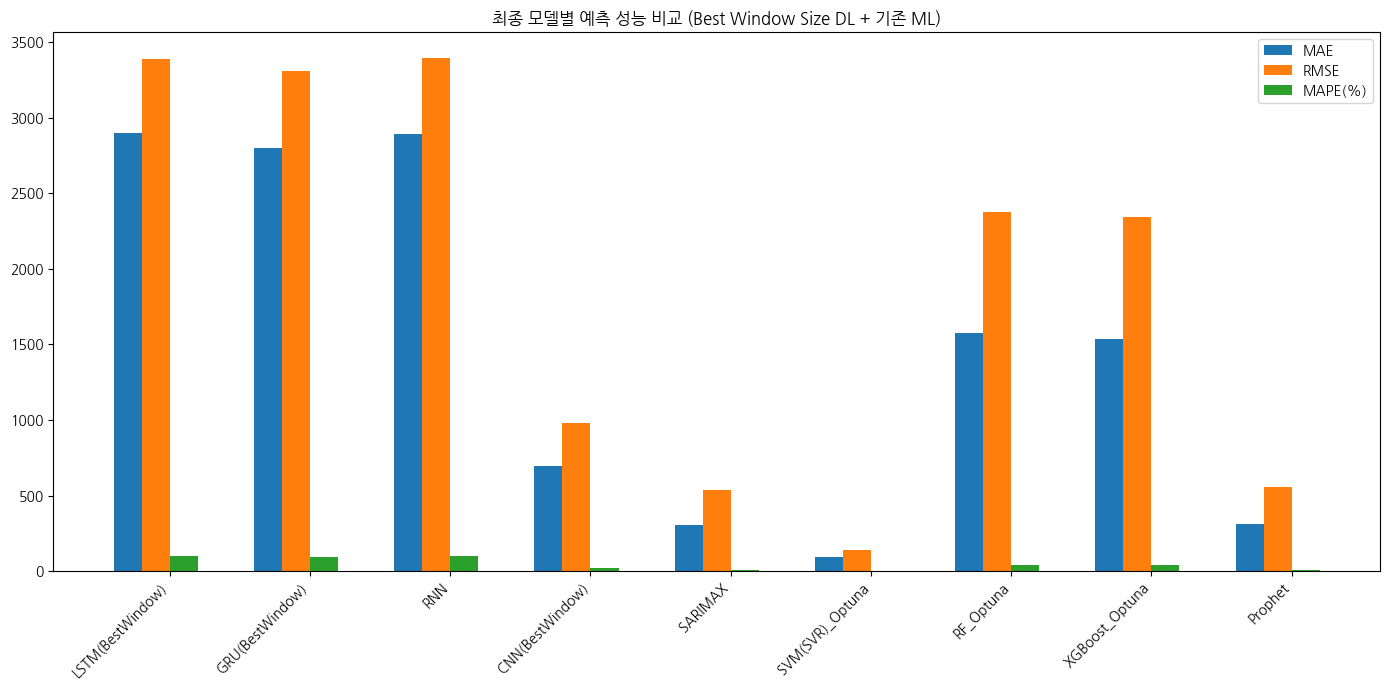

In [ ]:
########################################
# 12. 최종 결과 비교 및 시각화
########################################
# 모델 이름 수정 (Best Window Size DL 모델)
best_lstm_row['Model'] = 'LSTM(BestWindow)'
best_gru_row['Model'] = 'GRU(BestWindow)'
best_cnn_row['Model'] = 'CNN(BestWindow)'
sarimax_result['Model'] = 'SARIMAX'
svr_result_opt['Model'] = 'SVM(SVR)_Optuna'
rf_result_opt['Model'] = 'RF_Optuna'
xgb_result_opt['Model'] = 'XGBoost_Optuna'
prophet_result['Model'] = 'Prophet'

final_results_df_window = pd.DataFrame([
    best_lstm_row.to_dict(),
    best_gru_row.to_dict(),
    best_rnn_row.to_dict(),
    best_cnn_row.to_dict(),
    sarimax_result,
    svr_result_opt,
    rf_result_opt,
    xgb_result_opt,
    prophet_result,

])
final_results_df_window = final_results_df_window[['Model', 'Time Steps', 'Best Params', 'MAE', 'RMSE', 'MAPE']]
final_results_df_window.fillna('-', inplace=True)
print("\n=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===")
display(final_results_df_window)

final_results_df_window.rename(columns={'MAPE': 'MAPE(%)'}, inplace=True)
final_results_df_window['MAPE(%)'] = final_results_df_window['MAPE(%)'] * 100

plt.figure(figsize=(14,7))
bar_x = np.arange(len(final_results_df_window))
plt.bar(bar_x - 0.3, final_results_df_window['MAE'], 0.2, label='MAE')
plt.bar(bar_x - 0.1, final_results_df_window['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.1, final_results_df_window['MAPE(%)'], 0.2, label='MAPE(%)')
plt.xticks(bar_x, final_results_df_window['Model'], rotation=45, ha='right')
plt.title("최종 모델별 예측 성능 비교 (Best Window Size DL + 기존 ML)")
plt.legend()
plt.tight_layout()
plt.show()

gc.collect()
print("\n작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.")

In [ ]:
def evaluate_prophet_feature_importance(train_df, test_df, extra_regressors):
    # 1. 모든 regressors를 사용한 모델(기준 모델) 성능 평가
    baseline_model, baseline_forecast = train_prophet(train_df, test_df, extra_regressors)
    baseline_pred = baseline_forecast['yhat'].values
    baseline_perf = evaluate_performance(test_df['y'].values, baseline_pred, model_name="Prophet Baseline")

    # baseline_perf가 {'MAE': value, 'RMSE': value, 'MAPE': value, ...} 형태라고 가정합니다.

    importance_results = []
    for reg in extra_regressors:
        # 현재 Feature(reg)를 제외한 나머지 regressors를 사용
        regressors_subset = [r for r in extra_regressors if r != reg]
        model, forecast = train_prophet(train_df, test_df, extra_regressors=regressors_subset)
        pred = forecast['yhat'].values
        perf = evaluate_performance(test_df['y'].values, pred, model_name=f"Prophet without {reg}")

        # 성능 지표 차이 계산 (예: 기준 모델과 비교하여 MAE, RMSE, MAPE가 얼마나 증가 또는 감소했는지)
        # 값이 작아진다면 해당 변수의 제거가 성능 향상에 기여한 것으로 해석할 수 있습니다.
        diff_mae = baseline_perf['MAE'] - perf['MAE']
        diff_rmse = baseline_perf['RMSE'] - perf['RMSE']
        diff_mape = baseline_perf['MAPE'] - perf['MAPE']
        importance_results.append({
            'Dropped Regressor': reg,
            'MAE Diff': diff_mae,
            'RMSE Diff': diff_rmse,
            'MAPE Diff': diff_mape
        })
    return pd.DataFrame(importance_results)

# extra_regressors (feature_cols)를 사용하여 Prophet 모델의 Feature 중요도 평가
importance_df = evaluate_prophet_feature_importance(prophet_train, prophet_test, feature_cols)
print("Extra Regressor 제거에 따른 성능 변화:")
display(importance_df)



작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/23j9n_ae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/wo8ds3qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60995', 'data', 'file=/tmp/tmpv52r5hen/23j9n_ae.json', 'init=/tmp/tmpv52r5hen/wo8ds3qm.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modelh_5prvoy/prophet_model-20250214030821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/qggwo53b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/c_8ybait.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[Prophet Baseline] MAE=313.992, RMSE=556.858, MAPE=0.100


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/c5bfzh38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/i760gp61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31464', 'data', 'file=/tmp/tmpv52r5hen/c5bfzh38.json', 'init=/tmp/tmpv52r5hen/i760gp61.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modelgwvrrv0o/prophet_model-20250214030821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without SO2] MAE=315.555, RMSE=559.653, MAPE=0.100


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/2bqeh6u0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/winpa5pl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82552', 'data', 'file=/tmp/tmpv52r5hen/2bqeh6u0.json', 'init=/tmp/tmpv52r5hen/winpa5pl.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modelf1wa1wmq/prophet_model-20250214030822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without CO] MAE=312.634, RMSE=554.174, MAPE=0.100


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/f8slf44r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/38sqkulw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26087', 'data', 'file=/tmp/tmpv52r5hen/f8slf44r.json', 'init=/tmp/tmpv52r5hen/38sqkulw.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modelkpubd0eq/prophet_model-20250214030822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without O3] MAE=314.316, RMSE=557.382, MAPE=0.100


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/glhmbwf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/7buneik7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70690', 'data', 'file=/tmp/tmpv52r5hen/glhmbwf7.json', 'init=/tmp/tmpv52r5hen/7buneik7.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modeldv1sk2o8/prophet_model-20250214030822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without NO2] MAE=312.777, RMSE=555.161, MAPE=0.100


03:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/r6l014pb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/ogyw6iw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2779', 'data', 'file=/tmp/tmpv52r5hen/r6l014pb.json', 'init=/tmp/tmpv52r5hen/ogyw6iw1.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modelr4u_uuxl/prophet_model-20250214030822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 평균최고기온(℃)] MAE=307.703, RMSE=546.833, MAPE=0.100


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/5xpu8z8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/h9yi35s0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56755', 'data', 'file=/tmp/tmpv52r5hen/5xpu8z8_.json', 'init=/tmp/tmpv52r5hen/h9yi35s0.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_model0uhqm8q4/prophet_model-20250214030823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without 최대순간풍속(m/s)] MAE=313.788, RMSE=556.342, MAPE=0.100


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/ez70msd3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/bcazy9ty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1102', 'data', 'file=/tmp/tmpv52r5hen/ez70msd3.json', 'init=/tmp/tmpv52r5hen/bcazy9ty.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modelpw1hlquh/prophet_model-20250214030823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without PM10] MAE=314.386, RMSE=557.647, MAPE=0.100


03:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/v1tti9c6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/p64035s9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59979', 'data', 'file=/tmp/tmpv52r5hen/v1tti9c6.json', 'init=/tmp/tmpv52r5hen/p64035s9.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_model64gy2u5c/prophet_model-20250214030823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without 일조합(hr)] MAE=313.497, RMSE=555.958, MAPE=0.100


03:08:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/r00jeeb7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/b0kvuhu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2591', 'data', 'file=/tmp/tmpv52r5hen/r00jeeb7.json', 'init=/tmp/tmpv52r5hen/b0kvuhu9.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modeldep2wwon/prophet_model-20250214030824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without PM25_lag5] MAE=314.010, RMSE=556.942, MAPE=0.100


03:08:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/ln3l5qt7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv52r5hen/syibum16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53410', 'data', 'file=/tmp/tmpv52r5hen/ln3l5qt7.json', 'init=/tmp/tmpv52r5hen/syibum16.json', 'output', 'file=/tmp/tmpv52r5hen/prophet_modelstt8rcur/prophet_model-20250214030824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without Traffic] MAE=312.258, RMSE=554.257, MAPE=0.100


03:08:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without Cases_lag1] MAE=1036.679, RMSE=1612.544, MAPE=0.277
Extra Regressor 제거에 따른 성능 변화:


,Dropped Regressor,MAE Diff,RMSE Diff,MAPE Diff
0,SO2,-1.562521,-2.794910,-0.000242
1,CO,1.357564,2.684786,0.000082
2,O3,-0.324232,-0.523888,-0.000075
3,NO2,1.214519,1.697274,0.000291
4,평균최고기온(℃),6.289350,10.024929,0.000657
5,최대순간풍속(m/s),0.204143,0.516095,-0.000021
6,PM10,-0.394398,-0.788281,-0.000042
7,일조합(hr),0.494563,0.900238,0.000031
8,PM25_lag5,-0.017813,-0.083390,-0.000020
9,Traffic,1.734043,2.601657,0.000309


In [ ]:
## 0212 피드백 추가 k-select 방식을 통해 feature를 조사해볼것.